In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/Postgrado/Dataset/landmarks.zip -d /content/drive/MyDrive/Postgrado/Dataset/landmarks

In [ ]:
import os
import datetime
import imageio
import random
import numpy as np

from PIL import Image
import cv2
from skimage import io
from tqdm.auto import tqdm
from xml.etree import ElementTree
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid


import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models, datasets
from torchsummary import summary
import json
import time

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

class LandmarksDataset(Dataset):
    def __init__(self, train):
        self.root_dir = f'/content/drive/MyDrive/Postgrado/Dataset/landmarks/landmarks/{"train" if train else "test"}/statue/'
        self.root_landmarks = f'/content/drive/MyDrive/Postgrado/Dataset/landmarks/landmarks/{"train" if train else "test"}/statues128landmarks.json'
        with open(self.root_landmarks) as fp:
            self.landmark_points = json.load(fp)
        self.image_paths = []
        self.landmarks = []
        self.train = train
        filenames = os.listdir(self.root_dir)
        filenames = [filename for filename in filenames if filename.split('.')[1] in ('jpg', 'jpeg', 'png')]
        filenames = sorted(filenames, key=lambda fn: int(fn.split('.')[0]))
        
        for filename in filenames:
            path_to_img = os.path.join(self.root_dir, filename)
            self.image_paths.append(path_to_img)
            landmark = self.get_image_landmark(filename)
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')
        assert len(self.image_paths) == len(self.landmarks)

    def __len__(self):
        return len(self.image_paths)

    def get_image_landmark(self, filename):        
        landmark = []
        for num in range(68):
            x_coordinate = int(self.landmark_points[filename][str(num)]['x'])
            y_coordinate = int(self.landmark_points[filename][str(num)]['y'])
            landmark.append([x_coordinate, y_coordinate])
        return landmark

    def mask_image(self, image, inplace=False):
        # mask image
        min_mask_w, max_mask_w = 20, 60
        min_mask_h, max_mask_h = 20, 60
        mask_x = random.randint(0, 128 - max_mask_w)
        mask_width = random.randint(min_mask_w, max_mask_w)
        mask_y = random.randint(0, 128 - max_mask_h)
        mask_height = random.randint(min_mask_h, max_mask_h)
        if inplace:
          image[mask_x: mask_x + mask_width, mask_y: mask_y + mask_height] = 0
        else:
          new_image = np.copy(image)
          image[mask_x: mask_x + mask_width, mask_y: mask_y + mask_height] = 0
          return image


    def __getitem__(self, index):
        #image = io.imread(self.image_paths[index], as_gray=True)
        image = cv2.imread(self.image_paths[index], cv2.IMREAD_GRAYSCALE)
        self.mask_image(image, inplace=True)
        img_tensor = transform(image)
        landmarks = self.landmarks[index]
        landmarks = landmarks - 0.5
        landmarks_tensor = torch.from_numpy(landmarks)
        return img_tensor.to(device), landmarks_tensor.to(device)

In [ ]:
def visualize_image(image, landmarks):
    plt.figure(figsize = (3, 3))
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s = 3, c = 'black')
    #plt.axis('off')
    plt.show()
    
def visualize_batch(images_list, landmarks_list, size = 14, shape = (6, 6), title = None, save = None):
    fig = plt.figure(figsize = (size, size))
    grid = ImageGrid(fig, 111, nrows_ncols = shape, axes_pad = 0.08)
    for ax, image, landmarks in zip(grid, images_list, landmarks_list):
        landmarks = landmarks.view(-1, 2)
        ax.axis('off')

    if title:
        print(title)
    if save:
        plt.savefig(save)
    plt.show()

In [ ]:
train_dataset = LandmarksDataset(train = True)
test_dataset = LandmarksDataset(train = False)

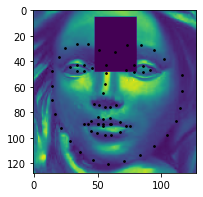

torch.Size([1, 128, 128])


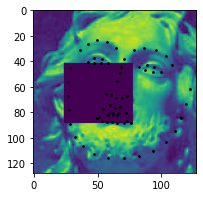

torch.Size([1, 128, 128])


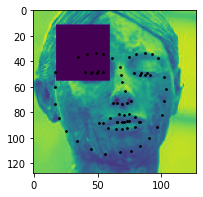

torch.Size([1, 128, 128])


In [ ]:
for i in range(3):
    image1, landmarks1 = train_dataset[i+200]
    visualize_image(image1[0].cpu(), landmarks1.cpu())
    print(image1.shape)

In [ ]:
len_train_set = len(train_dataset)
len_test_set = len(test_dataset)

print("The length of Train set is {}".format(len_train_set))
print("The length of Test set is {}".format(len_test_set))

#train_dataset , valid_dataset,  = torch.utils.data.random_split(train_dataset , [len_train_set, len_valid_set])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True)

The length of Train set is 748
The length of Test set is 130


In [ ]:
images, landmarks = next(iter(train_loader))

In [ ]:
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [ ]:
images.shape

torch.Size([64, 1, 128, 128])

In [ ]:
Network().cuda()(images)

tensor([[-1.6301, -0.6138,  0.6237,  ...,  1.0554,  0.5632, -0.1150],
        [-1.0832,  0.2635,  0.3292,  ...,  0.1851,  0.2592, -0.2054],
        [-0.9241,  0.2821,  0.5270,  ..., -0.0266,  0.2673, -0.1175],
        ...,
        [-1.4657, -0.6247,  0.8314,  ...,  0.6851,  0.4974, -0.4418],
        [-1.2315, -0.0522,  0.4556,  ...,  0.4828,  0.3868, -0.2547],
        [-0.8626,  0.4529,  0.5984,  ..., -0.1416,  0.1687, -0.0491]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
import sys
def log_step(step, total_step, loss, operation, logfile_path):
    with open(logfile_path, 'a') as logfile:
        if operation == 'train':
            print("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        else:
            print("Valid Steps: %d/%d  Loss: %.4f \n" % (step, total_step, loss))

def log_info(logfile_path, msg):
    with open(logfile_path, 'a') as logfile:
        print(msg, sep='', end='')
        logfile.write(msg)

## Load a pretrained model

In [ ]:
network = Network()
network.to(device)
network.load_state_dict(torch.load('/content/drive/MyDrive/Postgrado/Generated/resnet18_landmarkdetector/resnet18_landmarkdetector_2022-11-20_21:03:54.pth'))

<All keys matched successfully>

## Train model from scratch

In [ ]:
torch.autograd.set_detect_anomaly(True)
network = Network()
network.to(device)
train_id = datetime.datetime.now().strftime('resnet18_landmarkdetector_%Y-%m-%d_%H:%M:%S')
criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

epoch_array      = []
train_loss_array = []
valid_loss_array = []

loss_min = np.inf
num_epochs = 350

start_time = time.time()
logfile_path = f'/content/drive/MyDrive/Postgrado/Generated/resnet18_landmarkdetector/{train_id}.log'
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):
    
        images, landmarks = next(iter(train_loader))
        images = images
        landmarks = landmarks.view(landmarks.size(0),-1)
        
        predictions = network(images)
        
        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        log_info(logfile_path, "Train Steps: %d/%d  Loss: %.4f \n" % (step, len(train_loader), running_loss))
    network.eval()
    with torch.no_grad():
        
        for step in range(1,len(test_loader)+1):
            
            images, landmarks = next(iter(test_loader))
        
            images = images
            landmarks = landmarks.view(landmarks.size(0),-1)
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step
            log_info(logfile_path, "Valid Steps: %d/%d  Loss: %.4f \n" % (step, len(test_loader), running_loss))
    
    loss_train /= len(train_loader)
    loss_valid /= len(test_loader)
    
    log_info(logfile_path, '--------------------------------------------------\n')
    log_info(logfile_path, 'Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}\n'.format(epoch, loss_train, loss_valid))
    log_info(logfile_path, '--------------------------------------------------\n')
    epoch_array.append(epoch)
    train_loss_array.append(loss_train)
    valid_loss_array.append(loss_valid)
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        mark_id = ''
        torch.save(network.state_dict(), f'/content/drive/MyDrive/Postgrado/Generated/resnet18_landmarkdetector/{train_id}.pth') 
        log_info(logfile_path, "Minimum Validation Loss of {:.4f} at epoch {}/{}\n".format(loss_min, epoch, num_epochs))
        log_info(logfile_path, 'Model Saved\n\n')
     
log_info(logfile_path, 'Training Complete\n')
log_info(logfile_path, "Total Elapsed Time : {} s\n".format(time.time()-start_time))

Se truncaron las últimas líneas 5000 del resultado de transmisión.
Valid Steps: 10/17  Loss: 43.1837 
Valid Steps: 11/17  Loss: 42.5271 
Valid Steps: 12/17  Loss: 43.9388 
Valid Steps: 13/17  Loss: 42.9180 
Valid Steps: 14/17  Loss: 43.1538 
Valid Steps: 15/17  Loss: 44.2126 
Valid Steps: 16/17  Loss: 44.7884 
Valid Steps: 17/17  Loss: 44.3854 
--------------------------------------------------
Epoch: 146  Train Loss: 47.6701  Valid Loss: 44.3854
--------------------------------------------------
Minimum Validation Loss of 44.3854 at epoch 146/350
Model Saved

Train Steps: 1/12  Loss: 40.6032 
Train Steps: 2/12  Loss: 46.6503 
Train Steps: 3/12  Loss: 48.2432 
Train Steps: 4/12  Loss: 49.1716 
Train Steps: 5/12  Loss: 49.3321 
Train Steps: 6/12  Loss: 49.5179 
Train Steps: 7/12  Loss: 49.5483 
Train Steps: 8/12  Loss: 50.7636 
Train Steps: 9/12  Loss: 50.2633 
Train Steps: 10/12  Loss: 49.4773 
Train Steps: 11/12  Loss: 49.3990 
Train Steps: 12/12  Loss: 48.4912 
Valid Steps: 1/17  Los

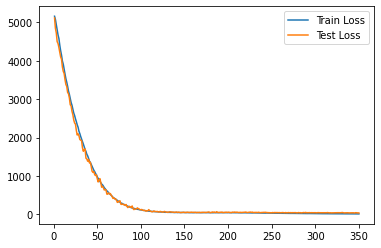

In [ ]:
plt.plot(epoch_array, train_loss_array, label='Train Loss')
plt.plot(epoch_array, valid_loss_array, label='Test Loss')
plt.legend(loc="upper right")
plt.show()

### Pruebas en datos de entrenamiento

Ground truth


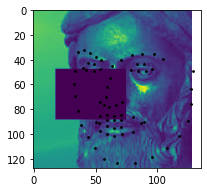

torch.Size([128, 128])

Predicted landmarks
torch.Size([68, 2])


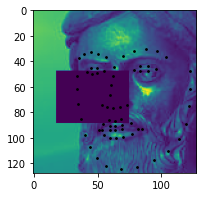

torch.Size([68, 2])


In [ ]:
images, real_landmarks = next(iter(train_loader))
predicted_landmarks = network(images)
predicted_landmarks = predicted_landmarks.detach()
print('Ground truth')
visualize_image(images[0][0].cpu(), real_landmarks[0].cpu())
print(images[0][0].cpu().shape)
print('\nPredicted landmarks')

predicted_landmark0 = torch.reshape(predicted_landmarks[0], (68, 2))
print(real_landmarks[0].shape)
visualize_image(images[0][0].cpu(), predicted_landmark0.cpu())
print(torch.reshape(predicted_landmarks[0], (68, 2)).shape)

### Pruebas en datos de testing

Ground truth


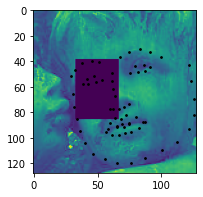

torch.Size([128, 128])

Predicted landmarks
torch.Size([68, 2])


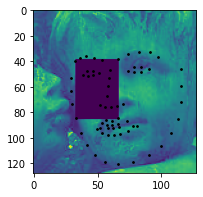

torch.Size([68, 2])


In [ ]:
images, real_landmarks = next(iter(test_loader))
predicted_landmarks = network(images)
predicted_landmarks = predicted_landmarks.detach()
print('Ground truth')
visualize_image(images[0][0].cpu(), real_landmarks[0].cpu())
print(images[0][0].cpu().shape)
print('\nPredicted landmarks')

predicted_landmark0 = torch.reshape(predicted_landmarks[0], (68, 2))
print(real_landmarks[0].shape)
visualize_image(images[0][0].cpu(), predicted_landmark0.cpu())
print(torch.reshape(predicted_landmarks[0], (68, 2)).shape)

(128, 128, 3)


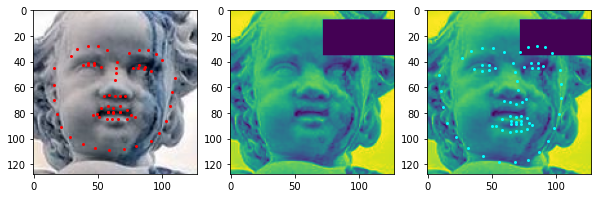

(128, 128, 3)


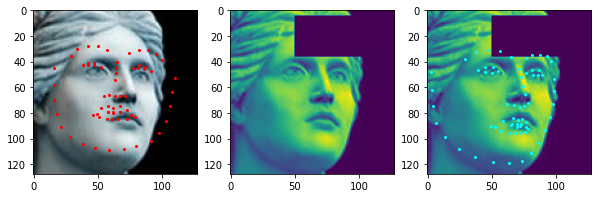

(128, 128, 3)


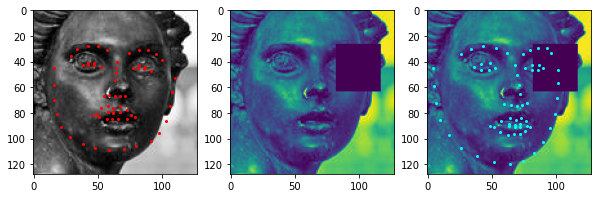

(128, 128, 3)


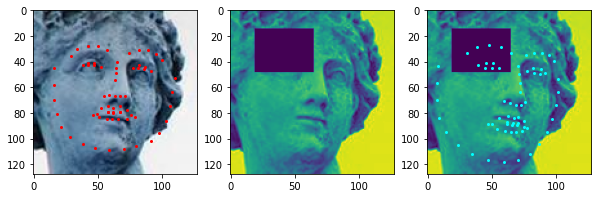

(128, 128, 3)


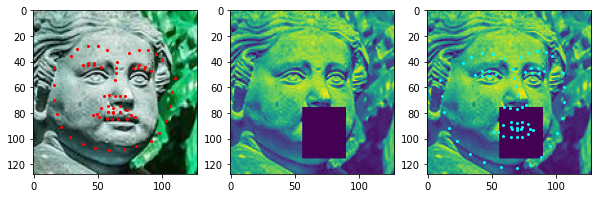

(128, 128, 3)


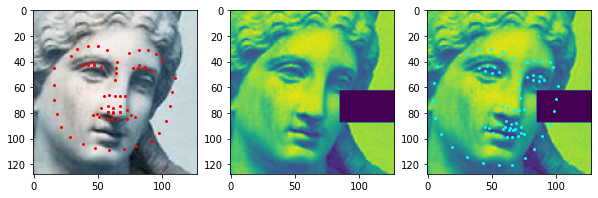

(128, 128, 3)


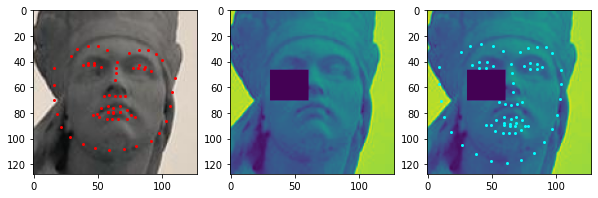

(128, 128, 3)


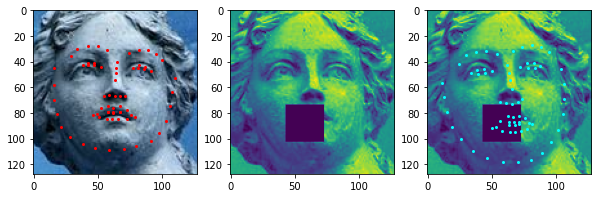

(128, 128, 3)


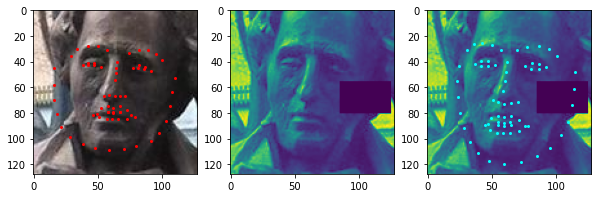

(128, 128, 3)


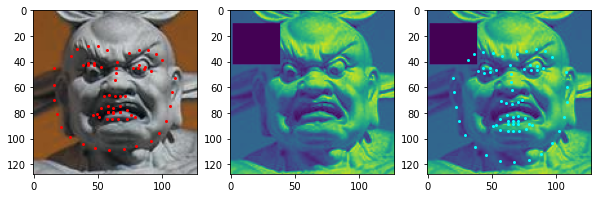

In [ ]:
from torch.autograd import Variable

test_path = '/content/drive/MyDrive/Postgrado/Dataset/landmarks/landmarks/test/statue/'
for filename in os.listdir(test_path)[:10]:

  f, axarr = plt.subplots(1,3, figsize=(10, 5))

  path = f'{test_path}/{filename}'
  img = cv2.imread(path)
  print(img.shape)

  ground_truth_landmarks = LandmarksDataset(train=False).get_image_landmark('0022.jpg')
  ground_truth_landmarks = np.array(ground_truth_landmarks).astype('float32')
  axarr[0].imshow(img)
  #axarr[0,1].imshow(image_datas[1])
  #axarr[1,0].imshow(image_datas[2])
  #plt.imshow(img)
  axarr[0].scatter(ground_truth_landmarks[:, 0], ground_truth_landmarks[:, 1], s=4, c = 'red')
  #plt.show()

  gs_img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  min_mask_w, max_mask_w = 20, 40
  min_mask_h, max_mask_h = 20, 40
  mask_x = random.randint(0, 128 - max_mask_w)
  mask_width = random.randint(min_mask_w, max_mask_w)
  mask_y = random.randint(0, 128 - max_mask_h)
  mask_height = random.randint(30, 60)
  gs_img[mask_x: mask_x + mask_width, mask_y: mask_y + mask_height] = 0

  axarr[1].imshow(gs_img)
  #plt.imshow(gs_img)
  #plt.show()

  
  predicted_landmarks = network(transforms.ToTensor()(gs_img).unsqueeze_(0).to(device))
  predicted_landmarks = predicted_landmarks.detach()
  predicted_landmark0 = torch.reshape(predicted_landmarks[0], (68, 2)).cpu()
  predicted_landmark0 = predicted_landmark0.numpy()

  #visualize_image(gs_img, predicted_landmark0)
  axarr[2].imshow(gs_img)
  axarr[2].scatter(predicted_landmark0[:, 0], predicted_landmark0[:, 1], s = 4, c = 'cyan')
  plt.show()

  predicted_landmark0[:, 1]